# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [95]:
def P1(num_examples=5):
### STUDENT START ###

    ## for the first 5 examples
    for i in range(num_examples):
        ## print the train label
        print "Label {} = {}".format(i+1, categories[train_labels[i]])
        ## print the text of the message
        print "Text = {}".format(train_data[i])
        print "\n---- end of label {} ----\n".format(i+1)
    
### STUDENT END ###
P1()

Label 1 = talk.religion.misc
Text = Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

---- end of label 1 ----

Label 2 = sci.space
Text = 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such ev

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [96]:
def P2():
### STUDENT START ###

    vector = CountVectorizer()
    f_vector = vector.fit_transform(train_data)
    
    print "A."
    print "   Size of the vocabulary = {}".format(f_vector.shape[1])
    print "   Avg # of non-zero feature/example = {}".format(f_vector.nnz/f_vector.shape[0])
    print "   Fraction of non-zero entries in the matrix = {:.3}".format(float(f_vector.nnz)/float(f_vector.shape[0]*f_vector.shape[1]))
    
    print "B."
    print "   0th feature string = {}".format(vector.get_feature_names()[0])
    print "   Last feature string = {}".format(vector.get_feature_names()[-1])
    
    own_vector = CountVectorizer()
    own_vector.vocabulary = ["atheism", "graphics", "space", "religion"]
    own_f_vector = own_vector.fit_transform(train_data)
    print "C."
    print "   Shape of vocabulary = {}".format(own_f_vector.shape)
    print "   Avg # of non-zero feature/example = {:.3}".format(float(own_f_vector.nnz)/float(own_f_vector.shape[0]))
    
    bi_tri_gram_vector = CountVectorizer(analyzer="char", ngram_range=(2,3))
    bi_tri_gram_f_vector = bi_tri_gram_vector.fit_transform(train_data)
    print "D."
    print "   Size of vocabulary = {}".format(bi_tri_gram_f_vector.shape[1])
    
    gr_10_vector = CountVectorizer(min_df=10)
    gr_10_vector_f_vector = gr_10_vector.fit_transform(train_data)
    print "E."
    print "   Size of vocabulary = {}".format(gr_10_vector_f_vector.shape[1])
    
    train_plus_dev_f_vector = vector.fit_transform(train_data+dev_data)
    dev_f_vector = vector.fit_transform(dev_data)
    print "F."
    print "   Size of train+dev vocabulary = {}".format(train_plus_dev_f_vector.shape[1])
    print "   Size of train vocabulary = {}".format(f_vector.shape[1])
    print "   Size of dev vocabulary = {}".format(dev_f_vector.shape[1])
    print "   Fraction of words in dev data missing from the vocabulary = {:.3}".format(float(train_plus_dev_f_vector.shape[1]-f_vector.shape[1])/float(dev_f_vector.shape[1]))
    
### STUDENT END ###
P2()

A.
   Size of the vocabulary = 26879
   Avg # of non-zero feature/example = 96
   Fraction of non-zero entries in the matrix = 0.0036
B.
   0th feature string = 00
   Last feature string = zyxel
C.
   Shape of vocabulary = (2034, 4)
   Avg # of non-zero feature/example = 0.268
D.
   Size of vocabulary = 35478
E.
   Size of vocabulary = 3064
F.
   Size of train+dev vocabulary = 30906
   Size of train vocabulary = 26879
   Size of dev vocabulary = 16246
   Fraction of words in dev data missing from the vocabulary = 0.248


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [60]:
def P3():
### STUDENT START ###
    
    ## using default CountVectorizer
    vector = CountVectorizer()
    f_vector = vector.fit_transform(train_data)
    
    ## KNN classifier
    knn_model = KNeighborsClassifier()
    k_values = {"n_neighbors": range(1,200)}
    ## use grid search to try different # of neighbors
    gs_knn = GridSearchCV(knn_model, k_values)
    gs_knn.fit(f_vector, train_labels)
    print "K-Nearest Neighbors Classifier:"
    print "Optimal k = {}; best KNN score = {:.3}".format(gs_knn.best_params_, gs_knn.best_score_)
    ## using most optimal k value, report f1 score
    knn_model_optimal = KNeighborsClassifier(n_neighbors=151)
    knn_model_optimal.fit(f_vector, train_labels)
    dev_f_vector = vector.transform(dev_data)
    knn_predicted = knn_model_optimal.predict(dev_f_vector)
    f1_knn = metrics.f1_score(dev_labels, knn_predicted, average="macro")
    print "KNN classifier F1 score = {:.3}\n".format(f1_knn)
    
    ## Multinomial Naive Bayes 
    mnb_classifier = MultinomialNB()
    alphas = {"alpha": [0.0001, 0.005, 0.001, 0.05, 0.01, 0, 0.1, 0.5, 1, 5, 10]}
    ## use grid search to try different alphas
    gs_mnb = GridSearchCV(mnb_classifier, alphas)
    gs_mnb.fit(f_vector, train_labels)
    print "Multinomial Naive Bayes Modle:"
    print "Optimal alpha = {}; best MNB score = {:.3}".format(gs_mnb.best_params_, gs_mnb.best_score_)
    ## using most optimal alpha, report f1 score
    mnb_classifier_optimal = MultinomialNB(alpha=0.005)
    mnb_classifier_optimal.fit(f_vector, train_labels)
    mnb_predicted = mnb_classifier_optimal.predict(dev_f_vector)
    f1_mnb = metrics.f1_score(dev_labels, mnb_predicted, average="macro")
    print "MNB classifier F1 score = {:.3}\n".format(f1_mnb)
    
    ## Logisitc regression model
    lr_model = LogisticRegression()
    Cs = {"C": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
    ## use grid search to try different C values
    gs_lr = GridSearchCV(lr_model, Cs)
    gs_lr.fit(f_vector, train_labels)
    print "Logistic Regression Model:"
    print "Optimal C = {}; best LR score = {:.3}".format(gs_lr.best_params_, gs_lr.best_score_)
    ## using optimal C, report f1 score
    lr_model_optimal = LogisticRegression(C=0.2)
    lr_model_optimal.fit(f_vector, train_labels)
    lr_predicted = lr_model_optimal.predict(dev_f_vector)
    f1_lr = metrics.f1_score(dev_labels, lr_predicted, average="macro")
    print "LR model F1 score = {:.3}\n".format(f1_lr)

    ## part c
    print "\nC."
    for c in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
        lr_model_part_c = LogisticRegression(C=c)
        lr_model_part_c.fit(f_vector, train_labels)
        sum_sq_weight = np.sum(lr_model_part_c.coef_**2, axis=1)
        print "   sum of squared weight for C={} = {}".format(c, sum_sq_weight)
    
### STUDENT END ###
P3()

K-Nearest Neighbors Classifier:
Optimal k = {'n_neighbors': 151}; best KNN score = 0.45
KNN classifier F1 score = 0.403

Multinomial Naive Bayes Modle:
Optimal alpha = {'alpha': 0.005}; best MNB score = 0.831
MNB classifier F1 score = 0.753

Logistic Regression Model:
Optimal C = {'C': 0.2}; best LR score = 0.776
LR model F1 score = 0.688


C.
   sum of squared weight for C=0.05 = [14.07262425 13.66910834 14.60408447 11.860762  ]
   sum of squared weight for C=0.1 = [27.13465361 24.65876281 27.45839548 23.0209231 ]
   sum of squared weight for C=0.15 = [38.90973476 34.18664487 38.90895049 33.22387613]
   sum of squared weight for C=0.2 = [49.73785405 42.74315203 49.32858903 42.66892916]
   sum of squared weight for C=0.25 = [59.80050057 50.56338264 58.94154095 51.46266296]
   sum of squared weight for C=0.3 = [69.28706599 57.87552132 67.90394574 59.75447583]
   sum of squared weight for C=0.35 = [78.23504083 64.70225039 76.3252427  67.60188425]
   sum of squared weight for C=0.4 = [86.

ANSWER:

a. Nearest neighbor does not work well for this problem becuase the feature representation is quite sparse, and thus looking at the nearest neighbor is not effective. 

b. Logistic regression doesn't work as well as Naive Bayes because logistic regression takes into account relationship between the features through linear models. Logistic regression also works best when the training data size is small compared to feature size. 

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [58]:
## find top features
def topFeatures(coef, vector):
    features_indices = []
    for i in range(coef.shape[0]):
        ## return indicies of 5 features with largest weights
        features_indices.extend(np.argsort(-coef[i])[:5])

    twenty_features = []
    for j in range(len(features_indices)):
        ## create 20 features, 5 features with the largest weights from 4 labels
        twenty_features.append(vector.get_feature_names()[features_indices[j]])

    features_table = []
    for ii in range(len(twenty_features)):
        features_table.append([twenty_features[ii], coef[0][features_indices[ii]], coef[1][features_indices[ii]], coef[2][features_indices[ii]], coef[3][features_indices[ii]]])

    for jj in features_table:
        print "{:10}{:14.3}{:14.3}{:14.3}{:14.3}".format(*jj)
        
def P4():
### STUDENT START ###

    ## unigram features
    unigram_vector = CountVectorizer()
    unigram_f_vector = unigram_vector.fit_transform(train_data)
    ## using optimal C from P3
    lr_unigram = LogisticRegression(C=0.2)
    lr_unigram.fit(unigram_f_vector, train_labels)
    print "Unigram features:"
    print "Features        {:13}{:16}{:12}{:9}".format(newsgroups_train.target_names[0], newsgroups_train.target_names[1], newsgroups_train.target_names[2], newsgroups_train.target_names[3])
    topFeatures(lr_unigram.coef_, unigram_vector)
    
    ## bigram features
    bigram_vector = CountVectorizer(analyzer="word", ngram_range=(2,2))
    bigram_f_vector = bigram_vector.fit_transform(train_data)
    # using optimal C from P3
    lr_bigram = LogisticRegression(C=0.2)
    lr_bigram.fit(bigram_f_vector, train_labels)
    print "\n\nBigram features:"
    print "Features        {:13}{:16}{:12}{:9}".format(newsgroups_train.target_names[0], newsgroups_train.target_names[1], newsgroups_train.target_names[2], newsgroups_train.target_names[3])
    topFeatures(lr_bigram.coef_, bigram_vector)


### STUDENT END ###
P4()

Unigram features:
Features        alt.atheism  comp.graphics   sci.space   talk.religion.misc
bobby              0.619        -0.151        -0.216        -0.293
atheism            0.616        -0.267        -0.266        -0.313
religion           0.615        -0.381          -0.5       -0.0197
atheists           0.607       -0.0869        -0.203        -0.421
islam              0.528       -0.0942        -0.213        -0.215
graphics          -0.503          1.26        -0.829        -0.471
image             -0.342         0.833        -0.488         -0.28
file              -0.214         0.808        -0.529        -0.373
3d                -0.232          0.71        -0.414        -0.238
computer        -0.00461         0.679        -0.427        -0.294
space             -0.819        -0.875          1.51        -0.741
orbit             -0.272        -0.425         0.762        -0.345
nasa              -0.346        -0.323         0.664        -0.315
launch            -0.274        -0.

ANSWER: In the bigram features table, the model assigned positive weights to more than one categories in certain features such as "cheers kent" and "with you". In addition, "cheers kent" appears twice in the top 5 for two different labels.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [59]:
def empty_preprocessor(s):
   return s

def better_preprocessor(s):
### STUDENT START ###
    
    ## lowercasing everything
    s = s.lower()
    ## replace sequences of #s with single token
    s = re.sub("\d+","*", s)
    ## remove non-letter characters
    s = re.sub("[^A-Za-z0-9 \\n]", " ", s)
    ## replace line breaks
    s = re.sub("\n", " ", s)
    return s

### STUDENT END ###

def P5():
### STUDENT START ###

    ## empty preprocessor
    empty_vector = CountVectorizer(preprocessor = empty_preprocessor)
    empty_f_vector = empty_vector.fit_transform(train_data)
    empty_dev_f_vector = empty_vector.transform(dev_data)
    ## using optimal C from P3
    lr_empty = LogisticRegression(C=0.2)
    lr_empty.fit(empty_f_vector, train_labels)
    empty_predicted = lr_empty.predict(empty_dev_f_vector)
    f1_empty = metrics.f1_score(dev_labels, empty_predicted, average="macro")
    
    ## better preprocessor
    ## use a built-in stop word list for English
    better_vector = CountVectorizer(preprocessor = better_preprocessor, stop_words = 'english')
    better_f_vector = better_vector.fit_transform(train_data)
    better_dev_f_vector = better_vector.transform(dev_data)
    ## using optimal C from P3
    lr_better = LogisticRegression(C=0.2)
    lr_better.fit(better_f_vector, train_labels)
    better_predicted = lr_better.predict(better_dev_f_vector)
    f1_better = metrics.f1_score(dev_labels, better_predicted, average="macro")
    
    print "Original vocabulary size = {}; original F1 = {:.3}".format(len(empty_vector.get_feature_names()), f1_empty)
    print "Improved vocabulary size = {}; improved F1 = {:.3}".format(len(better_vector.get_feature_names()), f1_better)
    print "F1 is improved by {:.3} points".format((f1_better-f1_empty)*100)
    
    

### STUDENT END ###
P5()

Original vocabulary size = 33291; original F1 = 0.685
Improved vocabulary size = 23702; improved F1 = 0.716
F1 is improved by 3.03 points


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number of non-zero weights using L2 regularization = 107516

L1 C   # of non-zero weights   accuracy
0.05                    207     0.643
 0.1                    364     0.692
0.15                    512     0.697
 0.2                    628     0.686
0.25                    757     0.685
 0.3                    862     0.678
0.35                    997     0.685
 0.4                   1057     0.683


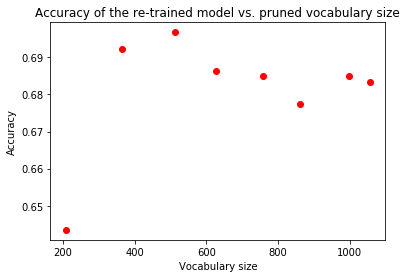

In [87]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    vector = CountVectorizer()
    f_vector = vector.fit_transform(train_data)
    
    ## train logistic regressiion model using L2
    lr_model_l2 = LogisticRegression(penalty="l2", tol=0.01)
    lr_model_l2.fit(f_vector, train_labels)
    print "Number of non-zero weights using L2 regularization = {}\n".format(np.count_nonzero(lr_model_l2.coef_))
    
    ## train logistic regression model using L1
    print "L1 C   # of non-zero weights   accuracy"
    accuracy_list = []
    vocab_list = []
    Cs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    for c in Cs:
        lr_model_l1 = LogisticRegression(penalty="l1", C=c, tol=0.01)
        lr_model_l1.fit(f_vector, train_labels)
        ## non-zero weights
        non_zero_indices = np.nonzero(lr_model_l1.coef_)[1]
        vocab_list.append(np.count_nonzero(lr_model_l1.coef_))
        ## reduced vocab of at leat one non-zero weight
        reduced_vocab = []
        for i in np.unique(non_zero_indices):
            reduced_vocab.append(vector.get_feature_names()[i])
        ## create new CountVectorizer with reduced vocab
        reduced_vector = CountVectorizer(vocabulary=reduced_vocab)
        reduced_vector_train = reduced_vector.fit_transform(train_data)
        reduced_vector_dev = reduced_vector.transform(dev_data)
        ## retrain a model using L2
        lr_model_l2.fit(reduced_vector_train, train_labels)
        ## compute accuracy
        accuracy = lr_model_l2.score(reduced_vector_dev, dev_labels)
        accuracy_list.append(accuracy)
        
        print "{:4}{:23}{:10.3}".format(c, np.count_nonzero(lr_model_l1.coef_), accuracy)
    
    ## plot graph showing accuracy of the re-trained model vs. the reduced vocab size
    plt.title("Accuracy of the re-trained model vs. pruned vocabulary size")
    plt.plot(vocab_list, accuracy_list, "ro")
    plt.ylabel("Accuracy")
    plt.xlabel("Vocabulary size")
    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [94]:
def P7():
### STUDENT START ###

    vector_t = TfidfVectorizer()
    f_vector_t = vector_t.fit_transform(train_data)
    dev_f_vector_t = vector_t.transform(dev_data)
    ## train logistic regression model with C=100
    lr = LogisticRegression(C=100, penalty="l2", tol=0.01)
    lr.fit(f_vector_t, train_labels)
    predicted = lr.predict(dev_f_vector_t)
    ## predicted probability
    predicted_proba = lr.predict_proba(dev_f_vector_t)
    ## maximum predicted probability
    max_predicted_proba = predicted_proba.max(axis=1)
    R = []
    for label in range(len(dev_labels)):
        ## maximum predicted probability / predicted probability of the correct label
        R.append(max_predicted_proba[label]/predicted_proba[label][dev_labels[label]])
    
    ## show the top 3 documents where R is largest
    print "Top 3 documents with largest R:\n"
    ## return top 3 indicies with largest R
    top_3_indices = np.argsort(R)[-3:]
    for index in range(len(top_3_indices)):
        print "Document {}".format(top_3_indices[index])
        print "R value = {:.3}".format(R[top_3_indices[index]])
        print "Predicted label: {}".format(newsgroups_train.target_names[predicted[top_3_indices[index]]])
        print "Actual label: {}".format(newsgroups_train.target_names[dev_labels[top_3_indices[index]]])
        print dev_data[top_3_indices[index]]
        print "\n---- end of document {} ----\n".format(top_3_indices[index])
    
    ## print confusion matrix to identify mistakes
    print "Confusion matrix:"
    print confusion_matrix(dev_labels, predicted)
        
## STUDENT END ###
P7()

Top 3 documents with largest R:

Document 665
R value = 3.27e+02
Predicted label: comp.graphics
Actual label: talk.religion.misc
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

---- end of document 665 ----

Document 607
R value = 3.85e+02
Predicted label: talk.religion.misc
Actual label: alt.atheism

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


---- end of document 607 ----

Document 215
R value = 9.27e+02
Predicted label: comp.graphics
Actual label: talk.religion.misc
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's"

ANSWER: Unlike CountVectorizer, which simply counts the word frequencies, TfidfVectorizer adjusts for the fact that some words appear more frequently. We can identify the mistakes the model is making by observing the confusion matrix. The model misclassifies and struggles with differentiating between 'alt.atheism' and 'talk.religion.misc.' This misclassification is acceptable to an extent as the two topics are similar in that they are about absence and/or existence of deities. One way to address this misclassification would be to use stop words to improve overall accuracy.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.